# Langevin Dynamics of a particle in a double well potential

 Prepare the code to do a simulation of the langevin dynamics of a particle in an **asymmetric** double well in the X axis and a harmonic well for Y and Z. How did you choose the integration step for the simulation?

- Would you know how to check that the observed probability density $P(x)$ from a sufficiently long simulation adequately matches the theoretical probability density?

- At a given temperature suitable enough to observe enough jump events between wells and calling $A$ the left well and $B$ the right well:
      - Calculate experimentally the probability of finding the system in $A$ ($P_A$) and the probability of finding it in $B$ ($P_B$). Could you calculate the same probabilities without doing a molecular dynamics simulation? Did you need a very long simulation to make the experimentally observed probabilities match the theoretical ones?
      - If with the same temperature you change the friction, will $P_A$ and $P_B$ change?
      - Can you calculate experimentally (from one or several trajectories) what is the probability that the particle jumps to well $B$ when it is in well $A$ ($P_{AB}$)? And the transition probability $P_{AB}$? What is the detailed equilibrium condition, is it fulfilled?
      - If with the same temperature you change the friction, will $P_{AB}$ and $P_{BA}$ change? Will the quotient $P_{AB}/P_{BA}$ change?



In [1]:
%matplotlib inline

import openmm
import openmm.app as app
import openmm.unit as unit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Simulation with harmonic potential

In [2]:
CHLORINE_MASS = 35.453 * unit.amu

In [3]:
def create_topology() -> openmm.app.Topology:
    """ Returns the topology of a Cl molecule
    """
    topology = app.Topology()
    chain = topology.addChain()
    residue = topology.addResidue("Cl", chain)

    chlorine = app.Element.getBySymbol("Cl")
    topology.addAtom("Cl", chlorine, residue)

    assert topology.getNumAtoms() == 1
    return topology

In [4]:
def double_well_potential() -> openmm.Force:
    """ Returns the double well potential.
    """
    K = 100.0 * unit.kilocalories_per_mole/unit.angstrom**2
    Eo = 6.0 * unit.kilocalories_per_mole/unit.angstrom**2
    C = 0.4 * 1/unit.angstrom**2
    M = -0.25 * unit.kilocalories_per_mole/unit.angstrom

    force = openmm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
    force.addGlobalParameter('K', K)
    force.addGlobalParameter('Eo', Eo)
    force.addGlobalParameter('C', C)
    force.addGlobalParameter('M', M)

    force.addParticle(0)
    return force

In [5]:
def create_system() -> openmm.System:
    """ Create the system with a chlorine atom.
    """
    system = openmm.System()
    system.addParticle(CHLORINE_MASS)
    system.addForce(double_well_potential())
    return system

In [6]:
def create_simulation(
        system: openmm.System,
        topology: openmm.app.Topology,
        temperature: float,
        friction: float,
        step: openmm.unit.Quantity,
        platform_name: str="CPU",
        initial_vel=0
) -> openmm.app.Simulation:
    """ Returns a simulation object.
    """
    temperature = temperature*unit.kelvin
    friction_coeff = friction/unit.picosecond

    integrator = openmm.LangevinIntegrator(
        temperature, friction_coeff, step
    )

    # Initial position and velocities
    pos = np.zeros((1, 3), np.float32) * unit.angstroms
    vel = np.ones((1, 3), np.float32) * initial_vel * unit.angstroms/unit.picoseconds

    platform = openmm.Platform.getPlatformByName(platform_name)

    simulation = app.Simulation(topology, system, integrator, platform)

    simulation.context.setPositions(pos)
    simulation.context.setVelocities(vel)

    return simulation

In [7]:
def prepare_simulation(temperature: float, friction: float,
                       step: openmm.unit, initial_vel: float=0):
    """ Returns a simulation object ready to run a simulation."""
    topology = create_topology()
    system = create_system()
    return create_simulation(
        system, topology, temperature, friction, step,
        initial_vel=initial_vel
    )

In [8]:
def run_sim(simulation: openmm.app.Simulation,
            step: openmm.unit.Quantity,
            sim_time: openmm.unit.Quantity,
            save_time: openmm.unit.Quantity):
    """ Run the simulation while saving the positions, times and velocities
        to numpy arrays

        Returns
        -------
        tuple[np.ndarray]
            An array for time, position and velocity.
    """
    n_steps_per_period = int(save_time/step)
    n_periods = int(sim_time/save_time)

    time = np.zeros([n_periods], np.float32) * unit.picoseconds
    position = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms
    velocity = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms/unit.picosecond
    pot_energy = np.zeros([n_periods], np.float32) * unit.kilocalorie_per_mole
    kin_energy = np.zeros([n_periods], np.float32) * unit.kilocalorie_per_mole

    for ii in tqdm(range(n_periods)):
        simulation.step(n_steps_per_period)
        state = simulation.context.getState(
            getPositions=True, getVelocities=True,
            getEnergy=True
        )

        time[ii] = state.getTime()
        position[ii] = state.getPositions()
        velocity[ii] = state.getVelocities()
        pot_energy[ii] = state.getPotentialEnergy()
        kin_energy[ii] = state.getKineticEnergy()

    return time, position, velocity, pot_energy, kin_energy


In [9]:
def plot_coordinates(time_array, positions):
    """ Plot the x, y and z coordinate against time. Each coordinate in
        a different plot.
    """

    plt.rcParams['figure.figsize'] = 18, 4

    for ii, axis_label in zip(range(3),['X','Y','Z']):
        plt.plot(time_array, positions[:,0,ii])
        plt.ylabel('{} ({})'.format(axis_label, positions.unit))
        plt.xlabel('time ({})'.format(time_array.unit))
        plt.show()

In [10]:
def plot_2d(positions):
    """ Plot the X coordinate against the Y coordinate.
    """
    plt.rcParams['figure.figsize'] = 5, 5

    plt.plot(positions[:,0,0], positions[:,0,1])
    plt.xlabel('X ({})'.format(positions.unit))
    plt.ylabel('Y ({})'.format(positions.unit))
    plt.show()

In [11]:
def plot_energy(time_array, kinetic_energy, potential_energy):
    """ Plot the kinetic and potential energy of the system.
    """
    plt.rcParams['figure.figsize'] = 18, 4

    plt.plot(time_array, potential_energy)
    plt.ylabel('Potential Energy ({})'.format(potential_energy.unit))
    plt.xlabel('time ({})'.format(time_array.unit))
    plt.show()

    plt.plot(time_array, kinetic_energy)
    plt.ylabel('Kinetic Energy ({})'.format(kinetic_energy.unit))
    plt.xlabel('time ({})'.format(time_array.unit))
    plt.show()


In [12]:
def simulate_and_plot(
        temperature: float, friction: float,
        step: float=0.1, initial_vel: float=0,
        sim_time=0.5 * unit.nanosecond,
        save_time=1.0* unit.picosecond
):
    """ Run a simulation and plot it.
    """
    step = step * unit.picosecond
    simulation = prepare_simulation(
        temperature, friction, step, initial_vel
    )
    time, positions, velocities, pot, kin = run_sim(
        simulation,
        step,
        sim_time=sim_time,
        save_time=save_time
    )

    plot_coordinates(time, positions)
    plot_2d(positions)
    plot_energy(time, kin, pot)

100%|██████████| 5000/5000 [00:32<00:00, 153.39it/s]


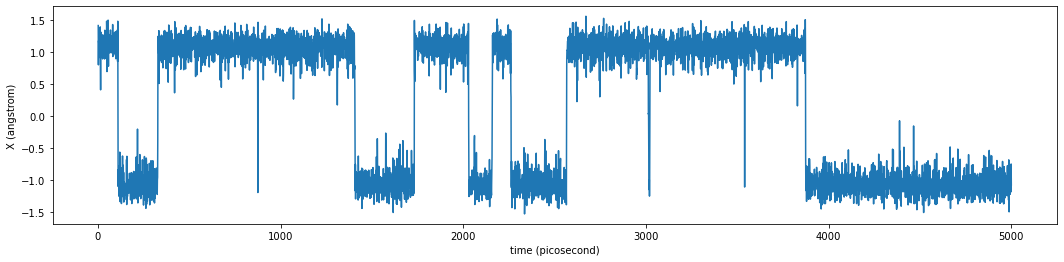

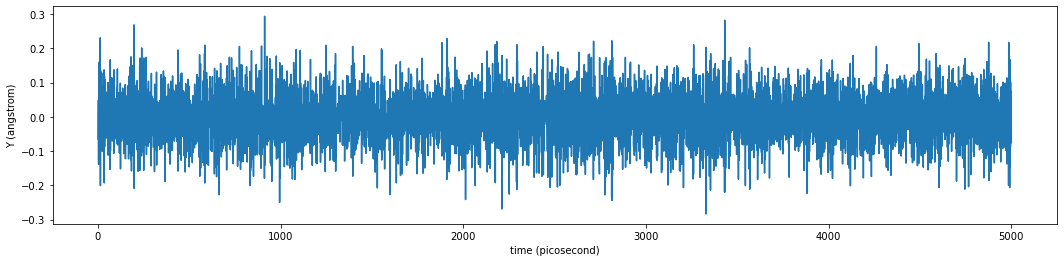

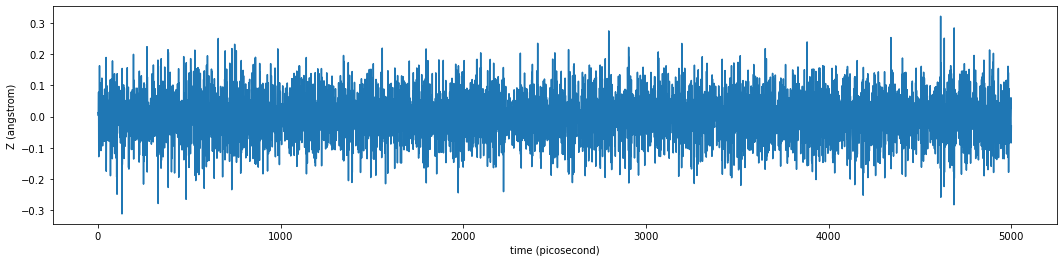

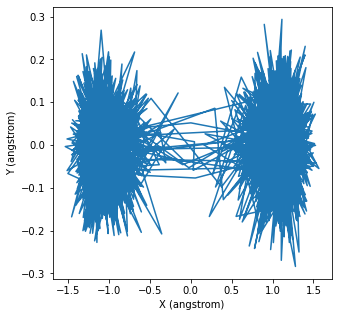

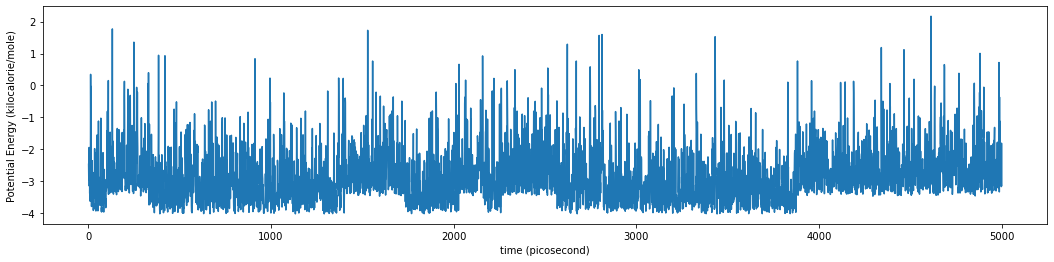

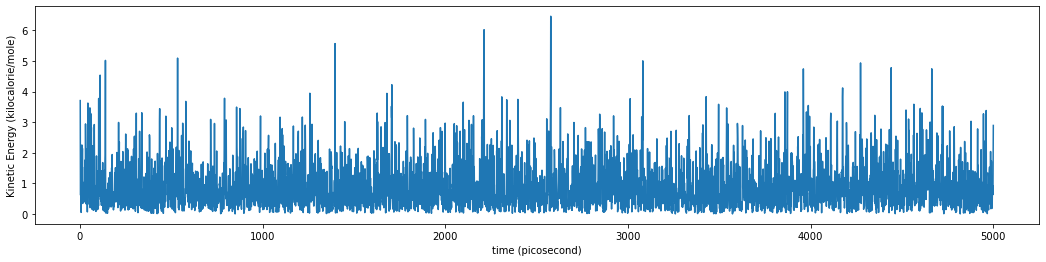

In [13]:
simulate_and_plot(
    temperature=300,
    friction=1.0,
    step=0.01,
    initial_vel=0,
    sim_time=5.0*unit.nanosecond,
    save_time=1.0*unit.picosecond
)

## Probability density



In [56]:
BOLTZMANN = openmm.unit.constants.BOLTZMANN_CONSTANT_kB

def probability_density(temperature: openmm.unit.Quantity,
                        positions: openmm.unit.Quantity) -> np.ndarray:
    """ Calculate the theoretical probability density in one
        dimension.
    """
    raise NotImplementedError



def plot_prob_density() -> None:
    """ Plot the theoretical probability density.
    """
    positions = np.linspace(-0.5, 0.5) * unit.angstroms
    prob = probability_density(temperature=300*unit.kelvin,
                               positions=positions
                               )

    plt.rcParams['figure.figsize'] = 18, 4

    plt.plot(positions, prob)
    plt.ylabel("P(X)")
    plt.xlabel('X ({})'.format(positions.unit))
    plt.show()

In [ ]:
plot_prob_density()

In [16]:
def plot_experimental_probability_density():

    step = 0.01 * unit.picosecond
    simulation = prepare_simulation(
        temperature=300,
        friction=0.1,
        step=step,
        initial_vel=0
    )
    _, positions, _, _, _ = run_sim(
        simulation,
        step,
        sim_time=1000.0 * unit.nanosecond,
        save_time=1.0 * unit.picoseconds
    )
    positions = np.squeeze(positions)

    plt.hist(positions[:, 0], bins="auto")
    plt.ylabel("P(X)")
    plt.xlabel('X (angstroms)')
    plt.show()

100%|██████████| 1000000/1000000 [2:01:51<00:00, 136.78it/s] 


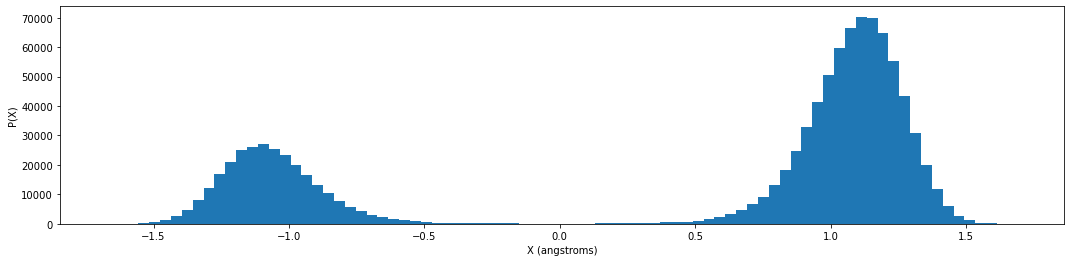

In [17]:
plot_experimental_probability_density()